In [2]:
from typing import Literal, List, Dict


import os
from dotenv import load_dotenv

import logging
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from IPython.display import Image, display

logging.basicConfig(level=logging.INFO)

load_dotenv(r'../.env');
print('OPENAI_API_KEY' in os.environ)

True


### Retrieval

In [ ]:
loader = PyPDFLoader(r'../01-docs/s41597-022-01877-3.pdf')

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)

docs = loader.load()
splits = text_splitter.split_documents(docs)

print(len(splits), '\n\n', splits[0].page_content)

28 

 1Scientific  Data |           (2022) 9:764  | https://doi.org/10.1038/s41597-022-01877-3
www.nature.com/scientificdata
the MetroPt dataset for predictive 
maintenance
Bruno Veloso  1,2,3 ✉, Rita P . Ribeiro2,4, João Gama2,3 & Pedro Mota Pereira2
The paper describes the MetroPT data set, an outcome of a Predictive Maintenance project with an 
urban metro public transportation service in Porto, Portugal. The data was collected in 2022 to develop 
machine learning methods for online anomaly detection and failure prediction. Several analog sensor 
signals (pressure, temperature, current consumption), digital signals (control signals, discrete signals), 
and GPS information (latitude, longitude, and speed) provide a framework that can be easily used 
and help the development of new machine learning methods. This dataset contains some interesting 
characteristics and can be a good benchmark for predictive maintenance models.
Background & Summary


In [3]:
# Generate Vector Store
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    collection_name='train_metadata',
    embedding_function=embeddings,
    persist_directory='./data/chroma_db'
)

ids = vector_store.add_documents(splits)
print(ids)

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


['73e145af-a613-40e5-9621-3c20f8c4410d', 'b4e879a1-b559-48c7-8d33-9478b572e222', '052dc9d2-c0cc-4df1-85ec-bb02d595d886', '90b992f6-d728-4b59-8449-9c2cdb409be1', '0089e65a-4be6-4de4-a4df-d95438fd2640', 'e552eef0-2966-4534-a893-3ac8eb839fcb', '187f4a12-a239-4ebb-8f85-3718a92cda86', 'ce8a3a13-51c1-4a5b-99de-f52884bc73c5', '2e84c0c1-f888-44f6-a050-1eb7f8ea74e4', 'a90a5eb5-9514-4007-ba7e-ffaa6d9031e6', '2c63620f-a82f-4df2-8846-4c67a53b9bc9', '3bb26880-5167-4121-85d1-89b31d88a90c', 'c0f33356-b66d-4b62-bbe1-797089e529f3', 'de10bbec-9af1-410b-9f0b-2f83ee5ca7b0', '01f8abed-62b3-4d44-b25b-0e4d89690cf3', '3ace220e-2326-4576-a1e5-9c39961290a2', 'c02ac59c-64a4-4916-9acc-77b713168f1c', '1fe5f1c7-2631-4906-a0e0-ccee96a68f02', 'f865885a-ce35-4b4f-80ee-e508aacdf3ec', 'd853665a-cdc1-49bf-ad92-6b0036d5c6af', '8d815831-21c3-428e-aa6d-67ee036e7a14', '18832e04-0397-4c79-a12a-700a73b7889f', 'b79add23-7a31-4db1-944f-681ab3687a9d', 'f11084f7-035e-496c-aef2-413962636173', '622c2f0d-e316-4a82-a8bc-092ad42913b5',

In [4]:
# Load & Test Vector Store
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = Chroma(
    collection_name='train_metadata',
    embedding_function=embeddings,
    persist_directory='./data/chroma_db'
)

In [6]:
results = vector_store.similarity_search('What unit is oil_temperature in?', k = 5)
results

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(id='2e84c0c1-f888-44f6-a050-1eb7f8ea74e4', metadata={'moddate': '2022-12-13T06:30:08+01:00', 'start_index': 2361, 'source': './s41597-022-01877-3.pdf', 'creationdate': '2022-12-12T19:28:27+05:30', 'title': 'The MetroPT dataset for predictive maintenance', 'page': 1, 'total_pages': 8, 'author': 'Bruno Veloso', 'producer': 'iText® 5.3.5 ©2000-2012 1T3XT BVBA (SPRINGER SBM; licensed version)', 'subject': 'Scientific Data, doi:10.1038/s41597-022-01877-3', 'page_label': '2', 'creator': 'Springer', 'keywords': ''}, page_content='•\t TP34 - Pressure generated at the pneumatic panel (bar).\n•\t H14 - Valve that is activated when the pressure read by the pressure switch of the command is above the oper-\nating pressure of 10.2 bar (bar).\n•\t DV_pressure 4 - Pressure exerted due to pressure drop generated when air dryers towers discharge the \nwater. When it is equal to zero, the compressor is working under load (bar).\n•\t Reservoirs4 - Pressure inside the air tanks installed on the 

In [7]:
for result in results:
    print('---- Result ----')
    print(result.page_content)
    print()

---- Result ----
•	 TP34 - Pressure generated at the pneumatic panel (bar).
•	 H14 - Valve that is activated when the pressure read by the pressure switch of the command is above the oper-
ating pressure of 10.2 bar (bar).
•	 DV_pressure 4 - Pressure exerted due to pressure drop generated when air dryers towers discharge the 
water. When it is equal to zero, the compressor is working under load (bar).
•	 Reservoirs4 - Pressure inside the air tanks installed on the trains (bar).
•	 Oil_Temperature5 - Temperature of the oil present on the compressor (°C).
•	 Flowmeter6 - Airflow was measured on the pneumatic control panel (m3/h).
•	 Motor_Current 7 - Motor’s current, which should present the following values: (i) close to 0 A when the 
compressor turns off; (ii) close to 4 A when the compressor is working offloaded; and (iii) close to 7 A when 
the compressor is operating under load (A);
Digital sensors. The eight digital signals are collected directly from the APU and GPS information.



### LLM Tool Calls

In [8]:
def query_outlier_events(start_ts: str, end_ts: str) -> List[dict]:
    """Queries the database for outlier events within a specified time range.

    Args:
        start_ts (str): Start timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).
        end_ts (str): End timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).

        start_ts and end_ts must be between 2022-01-01 and 2022-03-01.

    Returns:
        List[dict]: A list of dictionaries, each representing an outlier event with keys:
            event_id (int): Unique identifier for the outlier event
            outlier_start_ts (str): Start timestamp of the outlier event.
            outlier_end_ts (str): End timestamp of the outlier event.
            event_duration_in_secs (int): Duration of the outlier event in seconds.
    """
    with sqlite3.connect('./data/data.db') as con:
        df = pd.read_sql(f"""
            select 
                start_ts as outlier_start_ts
                ,end_ts as outlier_end_ts
                ,event_duration_in_secs
            from outlier_events
            where 
                model = 'puv'
                and event_duration_in_secs > 60*5
                and (
                    ('{start_ts}' <= start_ts and start_ts <= '{end_ts}')
                    or ('{start_ts}' <= end_ts and end_ts <= '{end_ts}')
                )
            order by outlier_start_ts asc
        """, con=con)
    
    return df.to_dict(orient='records')

In [9]:
def query_analog_sensor_importances(start_ts: str, end_ts: str) -> Dict[str, int]:
    """The anomaly detection model works by analyzing sensor data from different sensors
    and checking if sensors are out of their expected range for >5 minutes. If >5 sensors (out of 8)
    are out of their expected range, then the timestamp is flagged as an anomaly.

    This function queries the database and returns the number of seconds each sensor was out of its 
    expected range within the specified time range. This serves as a proxy for sensor importance.

    Args:
        start_ts (str): Start timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).
        end_ts (str): End timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).

        start_ts and end_ts must be between 2022-01-01 and 2022-03-01.

    Returns:
        dict[str, int]: Dictionary with key: sensor_name, value: number of seconds the sensor was out of its expected range.
    """
    with sqlite3.connect('./data/data.db') as con:
        df = pd.read_sql(f"""
            select
                sum(tp2_pred) as tp2_pred 
                ,sum(tp3_pred) as tp3_pred
                ,sum(h1_pred) as h1_pred
                ,sum(dv_pressure_pred) as dv_pressure_pred
                ,sum(reservoirs_pred) as reservoirs_pred
                ,sum(oil_temperature_pred) as oil_temperature_pred
                ,sum(flowmeter_pred) as flowmeter_pred
                ,sum(motor_current_pred) as motor_current_pred
            from prophet_results_agg
            where '{start_ts}' <= ds and ds <= '{end_ts}'
        """, con=con)
    return df.to_dict(orient='records')[0]

In [10]:
def query_digital_sensor_activations(start_ts: str, end_ts: str) -> Dict[str, int]:
    """Queries the database and returns the number of seconds each digital sensor was activated.

    Digital sensors are binary (0 or 1). 1 indicates the sensor is activated, while 0 indicates it is not.

    Args:
        start_ts (str): Start timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).
        end_ts (str): End timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).

        start_ts and end_ts must be between 2022-01-01 and 2022-03-01.

    Returns:
        dict[str, int]: Dictionary with key: sensor_name, value: number of seconds the sensor was activated.
    """
    with sqlite3.connect('./data/data.db') as con:
        df = pd.read_sql(f"""
            select
                sum(comp) as comp 
                ,sum(dv_electric) as dv_electric
                ,sum(towers) as towers
                ,sum(mpg) as mpg
                ,sum(lps) as lps
                ,sum(pressure_switch) as pressure_switch
                ,sum(oil_level) as oil_level
                ,sum(caudal_impulses) as caudal_impulses
            from train_data
            where '{start_ts}' <= ts and ts <= '{end_ts}'
        """, con=con)
    return df.to_dict(orient='records')[0]

In [11]:
def update_analog_sensor_plot_for_user(
        sensor_name: Literal[
            'tp2',
            'tp3',
            'h1',
            'dv_pressure',
            'reservoirs',
            'oil_temperature',
            'flowmeter',
            'motor_current'
        ],
        start_ts: str,
        end_ts: str
    ) -> None:
    """Plots analog sensor data for the user.

    Args:
        sensor_name (str): Name of the sensor to plot. Must be an analog sensor, names provided in function signature.
        start_ts (str): Start timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).
        end_ts (str): End timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).

        start_ts and end_ts must be between 2022-01-01 and 2022-03-01.

    Returns: None. Displays a plot to the user.
    """
    # Query
    with sqlite3.connect('./data/data.db') as con:
        df = pd.read_sql(f"""
            select 
                t.ts
                ,t.failure_id
                ,t.{sensor_name}
                ,r.puv_pred_filtered
                ,p.yhat_lower_expanded
                ,p.yhat_upper_expanded
                
            from train_data as t
                        
                left join consolidated_results as r
                    on r.ts = t.ts
                        
                left join prophet_results as p
                    on  p.ds = t.ts
                    and p.col = '{sensor_name}'
                        
            where '{start_ts}' <= t.ts and t.ts <= '{end_ts}'
        """, con=con, parse_dates=['ts'])

    # Plot
    ax = df.plot(
        x='ts', 
        y=[sensor_name, 'yhat_lower_expanded', 'yhat_upper_expanded'],
        figsize=(15, 5),
        color=['#003057', '#B3A369', '#B3A369'],
        legend=False
    );
    ax.set_title(f'Sensor Data: {sensor_name}');
    ax.set_xlabel(f'Time: {start_ts} to {end_ts}');

    # Modify Transparency
    for line, alpha in zip(ax.lines, [1., 0.3, 0.3]):
        line.set_alpha(alpha)

    # Hardcode Plot Limits -- to prevent fill_between from updating them
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax);
    ax.set_xlim(start_ts, end_ts);

    # Flag Anomalies
    ax.fill_between(
        df['ts'].to_list(),
        df[sensor_name].min() - 100,
        df[sensor_name].max() + 100,
        where=(df['puv_pred_filtered'] == 1).to_list(),
        color='blue',
        alpha=0.4,
        label='Anomaly'
    );

    # Plot Legend
    ax.legend();
    handles, labels = ax.get_legend_handles_labels()
    handles = [h for h, l in zip(handles, labels) if l != 'yhat_lower_expanded']
    labels = ['Sensor Data', 'Anomaly Threshold', 'Anomaly']
    ax.legend(handles, labels, fancybox=True, shadow=True);

    # Save to file
    fig = ax.get_figure()
    fig.savefig(r'analog_plot.png', dpi=300, bbox_inches='tight');
    plt.close(fig);

    return None

In [12]:
def update_digital_sensor_plot_for_user(
        sensor_name: Literal[
            'comp',
            'dv_electric',
            'towers',
            'mpg',
            'lps',
            'pressure_switch',
            'oil_level',
            'caudal_impulses'
        ],
        start_ts: str,
        end_ts: str
    ) -> None:
    """Plots analog sensor data for the user.

    Args:
        sensor_name (str): Name of the sensor to plot. Must be an analog sensor, names provided in function signature.
        start_ts (str): Start timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).
        end_ts (str): End timestamp in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time).

        start_ts and end_ts must be between 2022-01-01 and 2022-03-01.

    Returns: None. Displays a plot to the user.
    """
    # Query
    with sqlite3.connect('./data/data.db') as con:
        df = pd.read_sql(f"""
            select 
                t.ts
                ,t.failure_id
                ,t.{sensor_name}
                ,r.puv_pred_filtered
                
            from train_data as t
                        
                left join consolidated_results as r
                    on r.ts = t.ts
                        
            where '{start_ts}' <= t.ts and t.ts <= '{end_ts}'
        """, con=con, parse_dates=['ts'])

    # Plot
    ax = df.plot(
        x='ts', 
        y=sensor_name,
        figsize=(15, 5),
        color=['#003057'],
        legend=False,
        alpha=1.,
        label='Sensor Data'
    );
    ax.set_title(f'Sensor Data: {sensor_name}');
    ax.set_xlabel(f'Time: {start_ts} to {end_ts}');

    # Hardcode Plot Limits -- to prevent fill_between from updating them
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax);
    ax.set_xlim(start_ts, end_ts);

    # Flag Anomalies
    ax.fill_between(
        df['ts'].to_list(),
        df[sensor_name].min() - 100,
        df[sensor_name].max() + 100,
        where=(df['puv_pred_filtered'] == 1).to_list(),
        color='blue',
        alpha=0.4,
        label='Anomaly'
    );

    # Plot Legend
    ax.legend(loc='lower right', fancybox=True, shadow=True);
    plt.tight_layout()

    # Save to file
    fig = ax.get_figure()
    fig.savefig(r'digital_plot.png', dpi=300, bbox_inches='tight');
    plt.close(fig);

    return None

In [ ]:
query_outlier_events('2022-02-27 06:00:00', '2022-02-28 02:00:00')

In [ ]:
query_analog_sensor_importances('2022-02-27 08:53:55', '2022-02-27 09:01:23')

In [ ]:
query_digital_sensor_activations('2022-02-27 08:53:55', '2022-02-27 09:01:23')

In [ ]:
update_analog_sensor_plot_for_user(
    sensor_name='oil_temperature',
    start_ts='2022-02-27 06:00:00',
    end_ts='2022-02-28 02:00:00'
);

In [ ]:
update_digital_sensor_plot_for_user(
    sensor_name='dv_electric',
    start_ts='2022-02-27 06:00:00',
    end_ts='2022-02-28 02:00:00'
);

### LLM Interpretation

In [13]:
tools = [
    query_outlier_events, 
    query_analog_sensor_importances, 
    query_digital_sensor_activations,
    update_analog_sensor_plot_for_user, 
    update_digital_sensor_plot_for_user
]
llm = ChatOpenAI(model='gpt-4o')
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=True)

In [3]:
# Load vector store
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_db = Chroma(
    collection_name='train_metadata',
    persist_directory='./data/chroma_db',
    embedding_function=embeddings
)

def retrieve(state: MessagesState):
    print()
    print('================================= Context =================================')
    print(f'Prompt: {(msg := state["messages"][-1].content)}')

    retrieved_docs = vector_db.similarity_search(msg, k = 4)

    print(f'Retrieved: {len(retrieved_docs)}, Sample:')
    print(retrieved_docs[0].page_content)
    print()

    return {'context': retrieved_docs}

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [4]:
results = vector_db.similarity_search('test')

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [7]:
type(results[0])

langchain_core.documents.base.Document

In [15]:
sys_msg = SystemMessage(content="""
    You are a helpful analyst tasked with aiding users understand anomaly detection data.
                        
    Users are non-technical and responses should be clear, concise, and jargon-free.
    
    The data comes from a train that is monitored by 8 analog sensors and 8 digital sensors. 
    The analog sensors are: tp2, tp3, h1, dv_pressure, reservoirs, oil_temperature, flowmeter, motor_current
    The digital sensors are: comp, dv_electric, towers, mpg, lps, pressure_switch, oil_level, caudal_impulses
    
    Sensors record data once per second from 6AM to 2AM the next day each day.
                        
    The user will ask you questions about anomalies that the system has detected. 
    You have access to tools that can help you answer the user's questions. These tools include:
    1. query_outlier_events(start_ts: str, end_ts: str) -> Returns a list of outlier events between start_ts and end_ts.
    2. query_analog_sensor_importances(start_ts: str, end_ts: str) -> Returns a dictionary of sensor importances (in seconds out of range) between start_ts and end_ts.
    3. query_digital_sensor_activations(start_ts: str, end_ts: str) -> Returns a dictionary of digital sensor activations (in seconds activated) between start_ts and end_ts.
    4. update_analog_sensor_plot_for_user(sensor_name: str, start_ts: str, end_ts: str) -> Plots analog sensor data for the user.
    5. update_digital_sensor_plot_for_user(sensor_name: str, start_ts: str, end_ts: str) -> Plots digital sensor data for the user.
                        
    start_ts and end_ts must be between 2022-01-01 and 2022-03-01 and be in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time) format.
    
    When plotting anomaly events, make sure to always plot 3 hours before and after the event to provide context.
    
    There is also only space for one plot at a time, do not try to plot multiple sensors at once.

    The underlying anomaly detection model works by fitting 1 Prophet Forecasting Model per analog sensor.
    For each timestamp, if >5 analog sensors are out of their expected range for >5 minutes, then the timestamp is flagged as an anomaly.
    Digital sensors are not used in the anomaly detection model, but may be useful for understanding anomalies.
    
    Use these tools to gather data and generate plots to help the user understand the anomalies.
""")

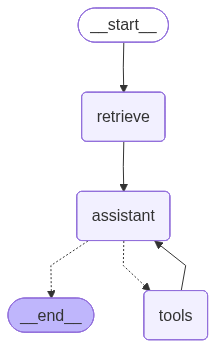

In [16]:
def assistant(state: MessagesState):
   return {'messages': [llm_with_tools.invoke([sys_msg] + state['messages'])]}

builder = StateGraph(MessagesState)

builder.add_node('retrieve', retrieve)
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'retrieve')
builder.add_edge('retrieve', 'assistant')
builder.add_conditional_edges(
    'assistant',
    tools_condition,
)
builder.add_edge('tools', 'assistant')

memory = MemorySaver()
llm_graph = builder.compile(checkpointer=memory)


display(Image(llm_graph.get_graph(xray=True).draw_mermaid_png()))

In [17]:
config = {'configurable': {'thread_id': '7'}}

messages = [HumanMessage(content='Were there any anomalies on or around 2022-02-27?')]

messages = llm_graph.invoke({'messages': messages}, config)
for m in messages['messages']:
    m.pretty_print()
    print()


================================= Context =================================
Prompt: Were there any anomalies on or around 2022-02-27?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved: 4, Sample:
5Scientific  Data |           (2022) 9:764  | https://doi.org/10.1038/s41597-022-01877-3
www.nature.com/scientificdatawww.nature.com/scientificdata/
technical Validation
Reported failures. The ground truth was provided by the company using maintenance reports. According to 
the reported information, the dataset has three catastrophic failures (cf. Table 2) during six months. Two failures 
are related to air leaks in the system, and another is an oil leak. This technical information can be used to annotate 
the dataset.
Failure 1 - Air leak on clients. This failure was an air leak on a pipe that feeds several clients on the systems, 
such as breaks, suspension, etc. The report provided by the maintenance teams showed a picture of a pipe that 
was blown up. In the second failure, the train recovered from the malfunction. In this case, the train needed to 
move to the maintenance building.



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================ Human Message =================================

Were there any anomalies on or around 2022-02-27?

================================== Ai Message ==================================
Tool Calls:
  query_outlier_events (call_h4jFJZIlIMS67Y4AHCiZjra7)
 Call ID: call_h4jFJZIlIMS67Y4AHCiZjra7
  Args:
    start_ts: 2022-02-26 03:00:00
    end_ts: 2022-02-28 03:00:00

================================= Tool Message =================================
Name: query_outlier_events

[{"outlier_start_ts": "2022-02-27 08:53:55", "outlier_end_ts": "2022-02-27 09:01:23", "event_duration_in_secs": 449}]

================================== Ai Message ==================================

Yes, there was an anomaly detected on February 27, 2022. It started at 08:53:55 AM and lasted until 09:01:23 AM, covering a duration of about 7.5 minutes. 

Would you like to explore which sensors were most affected during this anomaly, or if any digital sensors were activated?



In [18]:
messages = [HumanMessage(content='Why was that time period flagged as an anomaly?')]

messages = llm_graph.invoke({'messages': messages}, config)
for m in messages['messages']:
    m.pretty_print()
    print()


================================= Context =================================
Prompt: Why was that time period flagged as an anomaly?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved: 4, Sample:
was blown up. In the second failure, the train recovered from the malfunction. In this case, the train needed to 
move to the maintenance building.
Figure 6 shows a catastrophic drop on the air pressure near 23:00 due to a broken air pipe. This problem was 
classified as a severe malfunction, and the train needed to be removed from operation.
Failure 2 - Air leak on air dryer. The second failure is provoked by a malfunction of the pneumatic pilot valve 
that opens the drain pipes during the operation of the compressor. Figure 7 shows some anomalies on the regu
-
lar fill of air tanks and consumption by the train clients. Between 12:00 and 14:00, we can observe huge drops in 
air pressure, provoking an alarm for the train driver (LPS warning variable), the compressor tries to compensate 
for the lack of air pressure, and the train continues in operation. After 15:00, the APU behaviour stabilises due 
to the return of the normal pattern of the pneumatic pilot valve.

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================ Human Message =================================

Were there any anomalies on or around 2022-02-27?

================================== Ai Message ==================================
Tool Calls:
  query_outlier_events (call_h4jFJZIlIMS67Y4AHCiZjra7)
 Call ID: call_h4jFJZIlIMS67Y4AHCiZjra7
  Args:
    start_ts: 2022-02-26 03:00:00
    end_ts: 2022-02-28 03:00:00

================================= Tool Message =================================
Name: query_outlier_events

[{"outlier_start_ts": "2022-02-27 08:53:55", "outlier_end_ts": "2022-02-27 09:01:23", "event_duration_in_secs": 449}]

================================== Ai Message ==================================

Yes, there was an anomaly detected on February 27, 2022. It started at 08:53:55 AM and lasted until 09:01:23 AM, covering a duration of about 7.5 minutes. 

Would you like to explore which sensors were most affected during this anomaly, or if any digital sensors were activated?

==============

In [19]:
messages = [HumanMessage(content='Can you show me what oil_temperature looks like?')]

messages = llm_graph.invoke({'messages': messages}, config)
for m in messages['messages']:
    m.pretty_print()
    print()


================================= Context =================================
Prompt: Can you show me what oil_temperature looks like?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved: 4, Sample:
•	 TP34 - Pressure generated at the pneumatic panel (bar).
•	 H14 - Valve that is activated when the pressure read by the pressure switch of the command is above the oper-
ating pressure of 10.2 bar (bar).
•	 DV_pressure 4 - Pressure exerted due to pressure drop generated when air dryers towers discharge the 
water. When it is equal to zero, the compressor is working under load (bar).
•	 Reservoirs4 - Pressure inside the air tanks installed on the trains (bar).
•	 Oil_Temperature5 - Temperature of the oil present on the compressor (°C).
•	 Flowmeter6 - Airflow was measured on the pneumatic control panel (m3/h).
•	 Motor_Current 7 - Motor’s current, which should present the following values: (i) close to 0 A when the 
compressor turns off; (ii) close to 4 A when the compressor is working offloaded; and (iii) close to 7 A when 
the compressor is operating under load (A);
Digital sensors. The eight digital signals are collected directly from the APU and GPS informati

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================ Human Message =================================

Were there any anomalies on or around 2022-02-27?

================================== Ai Message ==================================
Tool Calls:
  query_outlier_events (call_h4jFJZIlIMS67Y4AHCiZjra7)
 Call ID: call_h4jFJZIlIMS67Y4AHCiZjra7
  Args:
    start_ts: 2022-02-26 03:00:00
    end_ts: 2022-02-28 03:00:00

================================= Tool Message =================================
Name: query_outlier_events

[{"outlier_start_ts": "2022-02-27 08:53:55", "outlier_end_ts": "2022-02-27 09:01:23", "event_duration_in_secs": 449}]

================================== Ai Message ==================================

Yes, there was an anomaly detected on February 27, 2022. It started at 08:53:55 AM and lasted until 09:01:23 AM, covering a duration of about 7.5 minutes. 

Would you like to explore which sensors were most affected during this anomaly, or if any digital sensors were activated?

==============

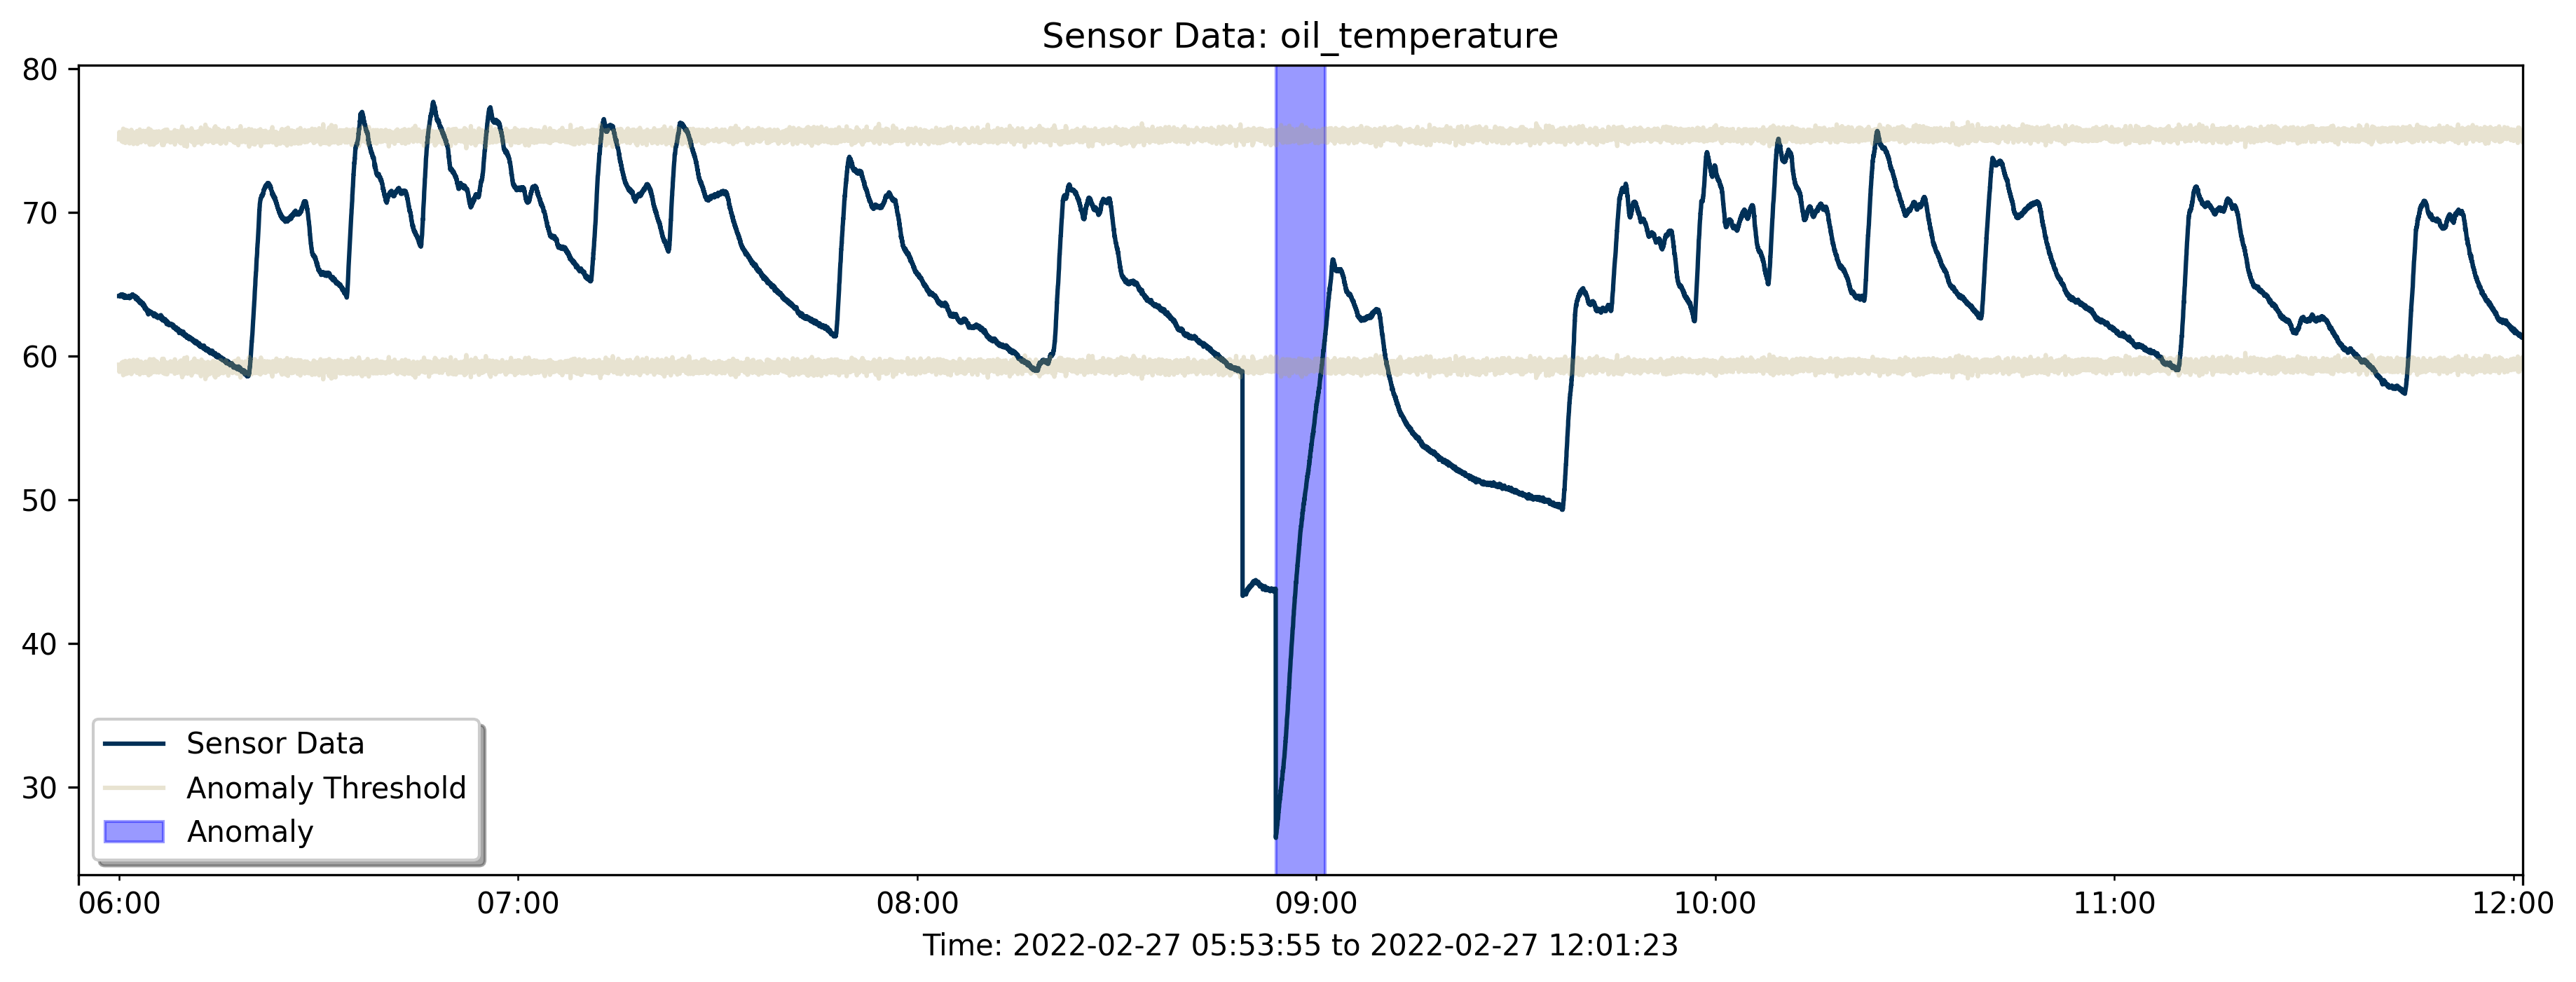

In [20]:
display(Image(r'analog_plot.png'))

In [21]:
messages = [HumanMessage(content='What unit is the sensor data for oil temperature in?')]

messages = llm_graph.invoke({'messages': messages}, config)
for m in messages['messages']:
    m.pretty_print()
    print()


================================= Context =================================
Prompt: What unit is the sensor data for oil temperature in?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved: 4, Sample:
•	 TP34 - Pressure generated at the pneumatic panel (bar).
•	 H14 - Valve that is activated when the pressure read by the pressure switch of the command is above the oper-
ating pressure of 10.2 bar (bar).
•	 DV_pressure 4 - Pressure exerted due to pressure drop generated when air dryers towers discharge the 
water. When it is equal to zero, the compressor is working under load (bar).
•	 Reservoirs4 - Pressure inside the air tanks installed on the trains (bar).
•	 Oil_Temperature5 - Temperature of the oil present on the compressor (°C).
•	 Flowmeter6 - Airflow was measured on the pneumatic control panel (m3/h).
•	 Motor_Current 7 - Motor’s current, which should present the following values: (i) close to 0 A when the 
compressor turns off; (ii) close to 4 A when the compressor is working offloaded; and (iii) close to 7 A when 
the compressor is operating under load (A);
Digital sensors. The eight digital signals are collected directly from the APU and GPS informati

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================ Human Message =================================

Were there any anomalies on or around 2022-02-27?

================================== Ai Message ==================================
Tool Calls:
  query_outlier_events (call_h4jFJZIlIMS67Y4AHCiZjra7)
 Call ID: call_h4jFJZIlIMS67Y4AHCiZjra7
  Args:
    start_ts: 2022-02-26 03:00:00
    end_ts: 2022-02-28 03:00:00

================================= Tool Message =================================
Name: query_outlier_events

[{"outlier_start_ts": "2022-02-27 08:53:55", "outlier_end_ts": "2022-02-27 09:01:23", "event_duration_in_secs": 449}]

================================== Ai Message ==================================

Yes, there was an anomaly detected on February 27, 2022. It started at 08:53:55 AM and lasted until 09:01:23 AM, covering a duration of about 7.5 minutes. 

Would you like to explore which sensors were most affected during this anomaly, or if any digital sensors were activated?

==============

In [22]:
messages = [HumanMessage(content='Earlier you said digital sensors were also activated. Can you show me what Towers looks like?')]

messages = llm_graph.invoke({'messages': messages}, config)
for m in messages['messages']:
    m.pretty_print()
    print()


================================= Context =================================
Prompt: Earlier you said digital sensors were also activated. Can you show me what Towers looks like?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved: 4, Sample:
1, 2022) from 8:00 to 10:30. Figure 3 depicts a snapshot of the data collected by the digital sensors referring to 
the APU for the same period reported in Fig. 2, i.e. on a normal operating day (Jan 1, 2022) from 8:00 to 10:30.
In Fig. 4, we show the data collected from the GPS module, which includes latitude, longitude, speed and 
GPS signal quality, again for the same period reported in Fig. 2. The positional data is important to derive if the 
train is parked or in operation (cf. Table  1). The parking zones are typically located at the end of each line or 
in some underground parks. There are no missing values in this data. When the satellite information is lost by 
entering a tunnel (cf. Figure 5), it is set to 0.
Fig. 2 Snapshot of the analog sensors under normal operating conditions.



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================ Human Message =================================

Were there any anomalies on or around 2022-02-27?

================================== Ai Message ==================================
Tool Calls:
  query_outlier_events (call_h4jFJZIlIMS67Y4AHCiZjra7)
 Call ID: call_h4jFJZIlIMS67Y4AHCiZjra7
  Args:
    start_ts: 2022-02-26 03:00:00
    end_ts: 2022-02-28 03:00:00

================================= Tool Message =================================
Name: query_outlier_events

[{"outlier_start_ts": "2022-02-27 08:53:55", "outlier_end_ts": "2022-02-27 09:01:23", "event_duration_in_secs": 449}]

================================== Ai Message ==================================

Yes, there was an anomaly detected on February 27, 2022. It started at 08:53:55 AM and lasted until 09:01:23 AM, covering a duration of about 7.5 minutes. 

Would you like to explore which sensors were most affected during this anomaly, or if any digital sensors were activated?

==============

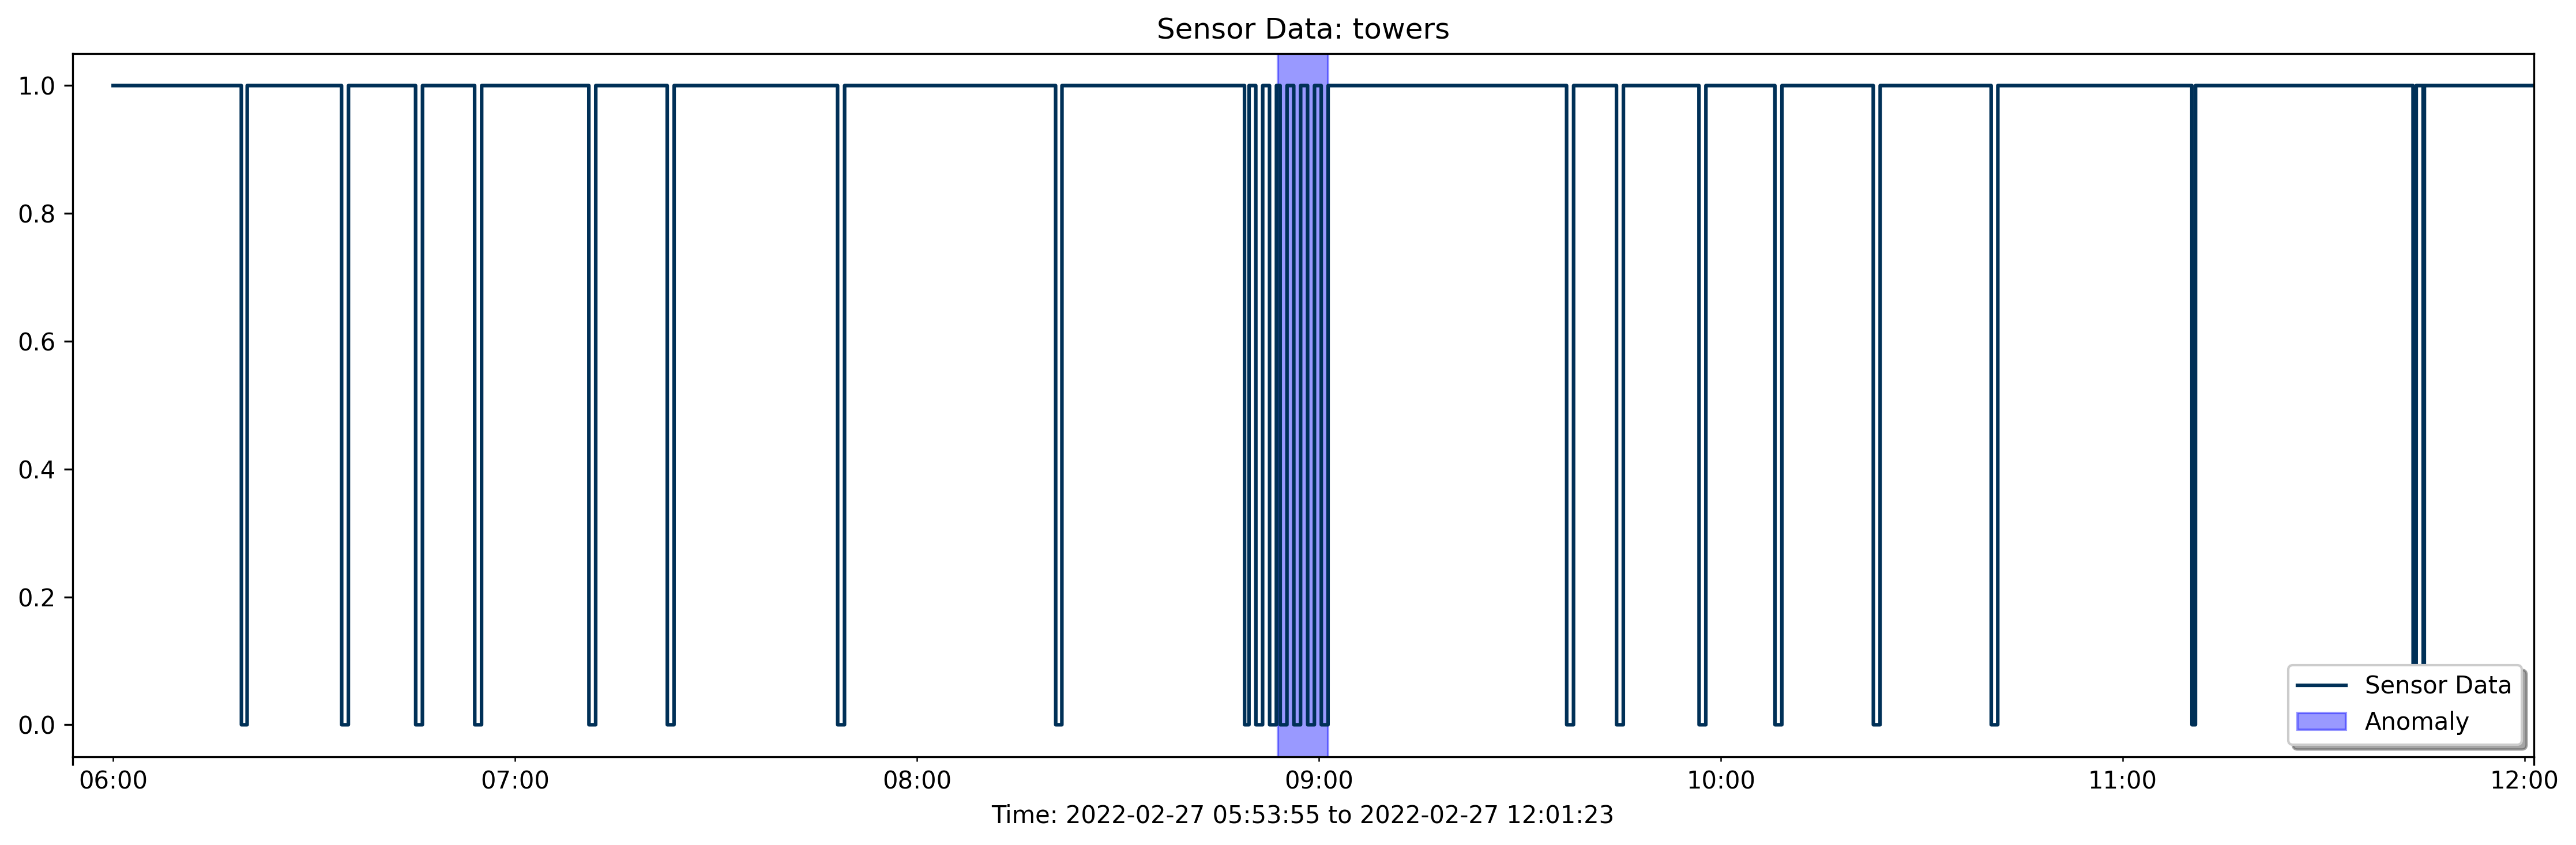

In [23]:
display(Image(r'digital_plot.png'))

In [24]:
messages = [HumanMessage(content='Are digital sensors used in anomaly detection in any way?')]

messages = llm_graph.invoke({'messages': messages}, config)
for m in messages['messages']:
    m.pretty_print()
    print()


================================= Context =================================
Prompt: Are digital sensors used in anomaly detection in any way?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Retrieved: 4, Sample:
-
ity of the failure ultimately yields more effective recovery plans.
The MetroPT dataset is a real-world dataset where the ground truth of anomalies is known from the compa-
ny’s maintenance reports. The objective is that it can be used as a benchmark dataset for Predictive Maintenance, 
where It will allow for fair comparisons between Machine Learning algorithms developed to detect anomalies 
based on sensor data collected as a continuous data flow.
Methods
A signal acquisition system was installed in the Air Production Unit (APU) of a train. The acquisition system 
follows a rigorous set of protocols and norms required to be used on railway vehicles:
1University Portucalense, Porto, 4200-072, Portugal. 2INESC TEC, Porto, 4200-465, Portugal. 3FEP - University of 
Porto, Porto, 4200-465, Portugal. 4FCUP - University of Porto, Porto, 4150-177, Portugal. ✉e-mail: bruno.m.veloso@
inesctec.pt
DaTa DeScR iPToR
oPeN



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================ Human Message =================================

Were there any anomalies on or around 2022-02-27?

================================== Ai Message ==================================
Tool Calls:
  query_outlier_events (call_h4jFJZIlIMS67Y4AHCiZjra7)
 Call ID: call_h4jFJZIlIMS67Y4AHCiZjra7
  Args:
    start_ts: 2022-02-26 03:00:00
    end_ts: 2022-02-28 03:00:00

================================= Tool Message =================================
Name: query_outlier_events

[{"outlier_start_ts": "2022-02-27 08:53:55", "outlier_end_ts": "2022-02-27 09:01:23", "event_duration_in_secs": 449}]

================================== Ai Message ==================================

Yes, there was an anomaly detected on February 27, 2022. It started at 08:53:55 AM and lasted until 09:01:23 AM, covering a duration of about 7.5 minutes. 

Would you like to explore which sensors were most affected during this anomaly, or if any digital sensors were activated?

==============